In [31]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import math
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os.path

# TODO CELL VELOCITIES
# TODO INSPECT THE MONOMERS; WRITE MONOMER CODE

# Setup

In [32]:
with_obstacles = False

data_from = 'Monomers/'
path = "Data/" + data_from

csv = ".csv"

def getConstants(config):
    name = 'constants.csv'
    constants = pd.read_csv("Data/" + config + name)
    out = {}
    out['avg'] = int(constants['average_particles_per_cell'])
    out['t'] = int(constants['timesteps'])
    out['delta_t'] = float(constants['time_lapse'])
    out['a'] = int(constants['cell_dim'])
    out['w'] = int(constants['width'])
    out['h'] = int(constants['height'])
    out['num_particles'] = int(constants['total_number_of_particles'])
    out['m'] = int(constants['particle_mass'])
    out['k_BT'] = float(constants['k_BT'])
    out['g'] = float(constants['g'])
    return out

constants = getConstants(data_from)

## Load Particles

In [36]:
timesteps = []
I = []
J = []
U = []
V = []
pivot = []

obstacles = None
if (with_obstacles):
    obstacles_path = path + 'constants_obstacles' + csv
    obstacles_csv = pd.read_csv(obstacles_path)
    obstacles = obstacles_csv[['x', 'y']]
    obstacle_radius = float(obstacles_csv['r'][0])
    
shown_x = float(constants['w'])
shown_y = float(constants['h'])

saved = './Data/'
saved_particles = data_from + 'particles.pkl'
file_particles = saved + saved_particles

def load_particles(path):
    columns = []
    num_timesteps = constants['t']
    x_columns = ['x{}'.format(it) for it in range(0, num_timesteps)]
    vx_columns = ['vx{}'.format(it) for it in range(0, num_timesteps)]
    y_columns = ['y{}'.format(it) for it in range(0, num_timesteps)]
    vy_columns = ['vy{}'.format(it) for it in range(0, num_timesteps)]
    columns.extend(x_columns)
    columns.extend(y_columns)
    columns.extend(vx_columns)
    columns.extend(vy_columns)
    particles = pd.DataFrame(columns = columns)

    if (os.path.isfile(file_particles)):
        print('Found saved particles_x and particles_y files!')
        particles = pd.read_pickle(file_particles)
        print('Loaded particles files.')
    else:
        # Loading particles
        print('Loading particles ..')
        filenames_particles = glob.glob('{}*.csv'.format(path))
        it = 0
        for file in filenames_particles:
            df = pd.read_csv(file)
            particles[['x{}'.format(it), 'y{}'.format(it), 'vx{}'.format(it), 'vy{}'.format(it)]] = df[['x', 'y', 'vx', 'vy']]
            it += 1
            if (it % 10 == 0):
                print('--loaded {}'.format(it))
        particles.to_pickle(file_particles)
        it = 0
        print('Particles loaded and saved!\n')
        # Particles loaded
    return particles


particles_path = '{parent}particles_av{av}'.format(parent = path, av=constants['avg'])    
particles = load_particles(path = particles_path)

Loading particles ..
--loaded 10
--loaded 20
--loaded 30
--loaded 40
--loaded 50
--loaded 60
--loaded 70
--loaded 80
--loaded 90
--loaded 100
--loaded 110
--loaded 120
--loaded 130
--loaded 140
--loaded 150
--loaded 160
--loaded 170
--loaded 180
--loaded 190
--loaded 200
--loaded 210
--loaded 220


KeyboardInterrupt: 

## Load Cells

In [34]:
cell_dim = float(constants['a'])
width = float(constants['w'])
height = float(constants['h'])
shown_cols = floor(width / cell_dim)
shown_rows = floor(height / cell_dim)

saved = './Data/'
saved_cells = data_from + 'cells.pkl'
file_cells = saved + saved_cells

columns = ['i', 'j', 'meanX', 'meanY', 'num']

def load_cells(path, columns, shown_rows, shown_cols):
    
    index = ['t']
    #if (os.path.isfile(file_cells)):
    #cells = pd.read_pickle(file_cells)
    #print(cells)
    #cells.set_index(index, inplace=True)
    #else:
    # Loading cells
    print('Loading cells')

    cells_timesteps = []

    it = 0
    filenames_cells = glob.glob('{}*.csv'.format(path))
    for file in filenames_cells:
        df = pd.read_csv(file)
        cells_timesteps.append(df)
        #df[[i,j]] = (df[[i,j]] + 1/2) * cell_dim
        #print(df.head())
        it += 1
        if (it % 10 == 0):
            print('--loaded {}'.format(it))
    #cells.to_pickle(file_cells)
    print('Cells loaded and saved!\n')
    # Cells loaded
    return cells_timesteps
    
def prepare_cells(cells_timesteps, columns, shown_rows, shown_cols):
    # Preparing cell values
    print('Preparing cell values ..')

    array_i = np.arange(0, shown_rows)
    array_j = np.arange(0, shown_cols)
    I,J = np.meshgrid(array_j, array_i)

    U = []
    V = []

    i = columns[0]
    j = columns[1]
    vx = columns[2]
    vy = columns[3]
    num = columns[4]

    pivots = []
    for df in cells_timesteps:
        # only the rows and cols above 0
        # and below shown_rows, shown_cols
        # this is to 
        # --1. no vaccuum around simulated region
        # --2. I,J are fixed size
        U_inner = []
        V_inner = []
        for it in array_i: # TODO: check this code something seems foul (row, cols, but only using rows)
            temp = df.loc[df[i] == it]
            u = np.array(temp[vx])
            U_inner.append(u)
            v = np.array(temp[vy])
            V_inner.append(v)
        U.append(np.array(U_inner))#, dtype = object))
        V.append(np.array(V_inner))#, dtype = object))

        pivot = df.pivot(index = i, columns = j, values = num)
        pivots.append(pivot)

    print('Cell preparation complete!')
    return I,J,U,V, pivots
    # Cell preparation complete
    
cells_path = path + 'cells_av{}'.format(constants['avg'])
cells_timesteps = load_cells(cells_path, columns, shown_rows, shown_cols)
I,J,U,V,pivots = prepare_cells(cells_timesteps, columns, shown_rows, shown_cols)

Loading cells
--loaded 10
--loaded 20
--loaded 30
--loaded 40
--loaded 50
--loaded 60
--loaded 70
--loaded 80
--loaded 90
--loaded 100
--loaded 110
--loaded 120
--loaded 130
--loaded 140
--loaded 150
--loaded 160
--loaded 170
--loaded 180
--loaded 190
--loaded 200
--loaded 210
--loaded 220
--loaded 230
--loaded 240
--loaded 250
--loaded 260
--loaded 270
--loaded 280
--loaded 290
--loaded 300
--loaded 310
--loaded 320
--loaded 330
--loaded 340
--loaded 350
--loaded 360
--loaded 370
--loaded 380
--loaded 390
--loaded 400
--loaded 410
--loaded 420
--loaded 430
--loaded 440
--loaded 450
--loaded 460
--loaded 470
--loaded 480
--loaded 490
--loaded 500
--loaded 510
--loaded 520
--loaded 530
--loaded 540
--loaded 550
--loaded 560
--loaded 570
--loaded 580
--loaded 590
--loaded 600
--loaded 610
--loaded 620
--loaded 630
--loaded 640
--loaded 650
--loaded 660
--loaded 670
--loaded 680
--loaded 690
--loaded 700
--loaded 710
--loaded 720
--loaded 730
--loaded 740
--loaded 750
--loaded 760
--loade

## Load Monomers

In [35]:
def load_monomers(path, constants):
    num_timesteps = constants['t']
    
    
    monomers_t = []

    # Loading particles
    print('Loading Monomers ..')
    filenames_monomers = glob.glob('{}*.csv'.format(path))
    for it, file in enumerate(filenames_monomers):
        monomers_t.append(pd.read_csv(file))
        if (it % 10 == 0):
            print('--loaded {}'.format(it))
    print('Monomers loaded and saved!\n')
    # Monomers loaded
    return monomers_t

monomers_t = load_monomers(path + f'monomers_av{constants["avg"]}', constants)

Loading Monomers ..
--loaded 0
--loaded 10
--loaded 20
--loaded 30
--loaded 40
--loaded 50
--loaded 60
--loaded 70
--loaded 80
--loaded 90
--loaded 100
--loaded 110
--loaded 120
--loaded 130
--loaded 140
--loaded 150
--loaded 160
--loaded 170
--loaded 180
--loaded 190
--loaded 200
--loaded 210
--loaded 220
--loaded 230
--loaded 240
--loaded 250
--loaded 260
--loaded 270
--loaded 280
--loaded 290
--loaded 300
--loaded 310
--loaded 320
--loaded 330
--loaded 340
--loaded 350
--loaded 360
--loaded 370
--loaded 380
--loaded 390
--loaded 400
--loaded 410
--loaded 420
--loaded 430
--loaded 440
--loaded 450
--loaded 460
--loaded 470
--loaded 480
--loaded 490
--loaded 500
--loaded 510
--loaded 520
--loaded 530
--loaded 540
--loaded 550
--loaded 560
--loaded 570
--loaded 580
--loaded 590
--loaded 600
--loaded 610
--loaded 620
--loaded 630
--loaded 640
--loaded 650
--loaded 660
--loaded 670
--loaded 680
--loaded 690
--loaded 700
--loaded 710
--loaded 720
--loaded 730
--loaded 740
--loaded 750
--l

In [ ]:
for it, df in enumerate(monomers_t):
    plt.plot(df['x'], df['y'], 'o', markersize = 30 * point_size, color = 'red')
    plt.xlim((0, 20))
    plt.ylim((0, 20))
    plt.savefig(f"Test/monomer_plot_{it}.png")

Animating monomer ...
animating


KeyboardInterrupt: 

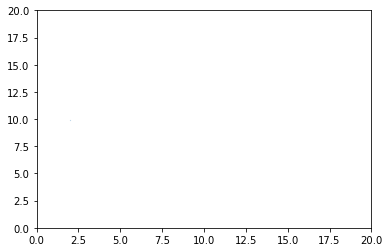

In [43]:
from matplotlib import animation

print('Animating monomer ...')
# First set up the figure, the axis, and the plot element we want to animate
point_size = 0.1
fig = plt.figure()
ax = plt.axes(xlim=(0, 20), ylim=(0, 20))
initial_data = monomers_t[0]
scatter, = ax.plot(initial_data['x'], initial_data['y'], "o", markersize = point_size)
#ax.plot(monomers_t[0]['x'], monomers_t[0]['y'], markersize = 20 * point_size, color = 'red')


# initialization function: plot the background of each frame
def init():
    #quiv.set_data([], [], [], [])
    return scatter,

# animation function.  This is called sequentially
def animate(it):
    monomers = monomers_t[it]
    scatter.set_xdata(monomers['x'])
    scatter.set_ydata(monomers['y'])
    if (it % 10 == 0):
        print('--Created {} frame.\n'.format(it))
    return scatter,

# call the animator.  blit=True means only re-draw the parts that have changed.
print('animating')
anim = animation.FuncAnimation(fig, animate, #init_func=init,
                               frames=timesteps, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('./Assets/monomer_animation.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
print('Animated and saved!')

plt.close()

# Plot

Plotting data ..
Data plotted and saved!


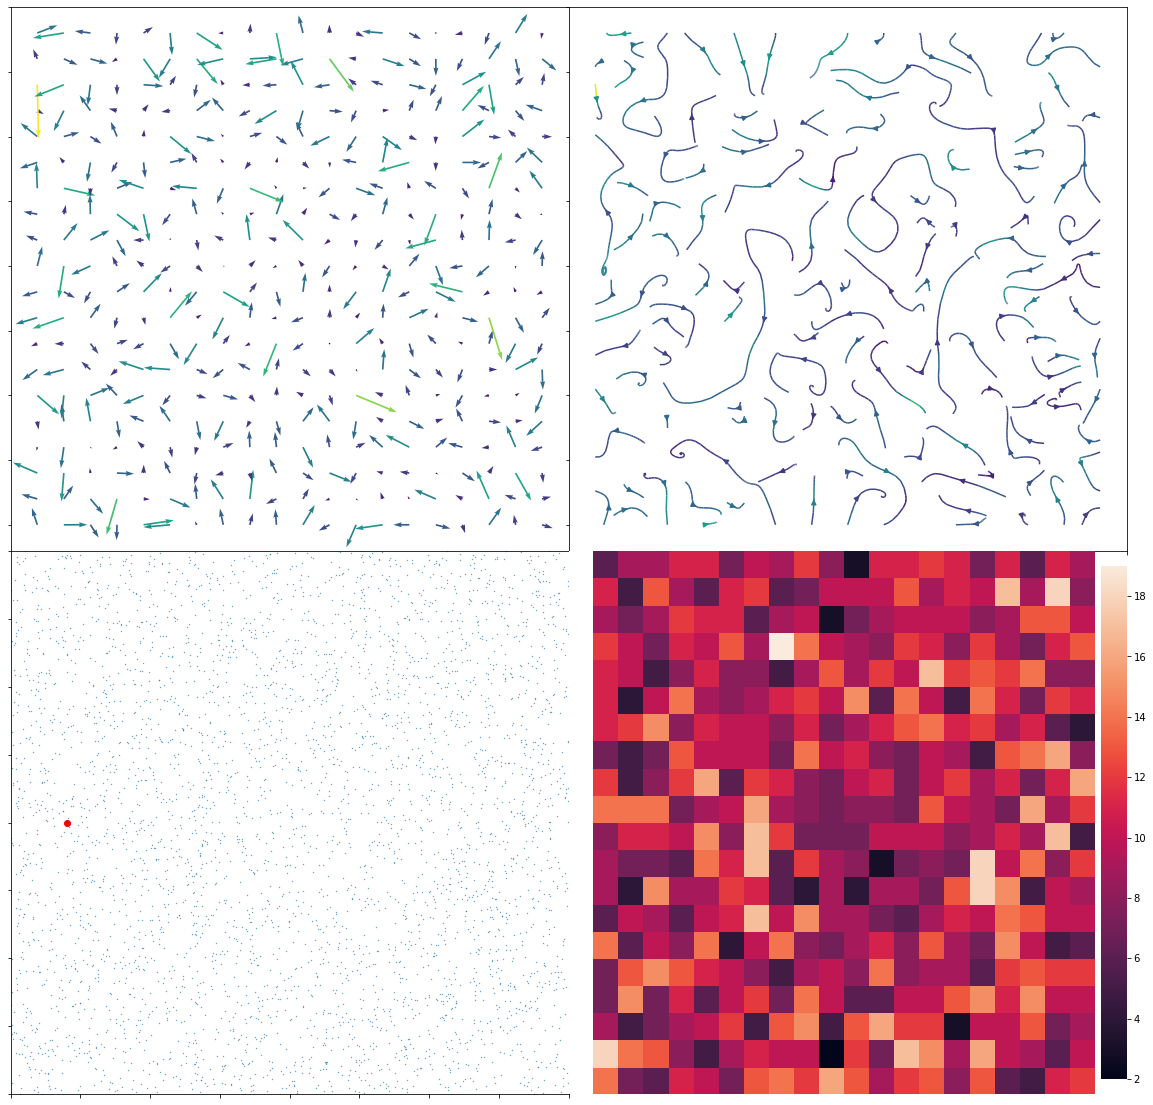

In [30]:
# Plotting
#with (sns.plotting_context(sns.set())):
x_0_region = 0
x_max_region = int(constants['w'])
y_0_region = 0
y_max_region = int(constants['h'])

streamplot_density = [0.5, 1]

print('Plotting data ..')
fig = plt.figure(figsize=(20,20))
ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    #a.set_aspect('equal')
    
fig.subplots_adjust(wspace=0, hspace=0)

color = np.sqrt(U[0]**2 + V[0]**2)
point_size = 0.3

#circles = []
if with_obstacles:
    for index, o in obstacles.iterrows():
        circle1 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'gray')
        circle2 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'gray')
        #circle3 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'black')
        #circles.append(circle)
        ax[1].add_artist(circle1)
        ax[2].add_artist(circle2)
        #ax[3].add_artist(circle3)
        #ax[0].xaxis.set_ticks([])
#ax[0].yaxis.set_ticks([])
ax[0].quiver(I, J, U[0], V[0], color)
ax[0].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region-1,y_max_region))

#ax[1].xaxis.set_ticks([])
#ax[1].yaxis.set_ticks([])
ax[1].streamplot(I, J, U[0], V[0], color=color, density = streamplot_density) # grid
ax[1].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region-1,y_max_region))

#ax[2].xaxis.set_ticks([])
#ax[2].yaxis.set_ticks([])
ax[2].plot(particles['x0'], particles['y0'], "o", markersize = point_size)
monomers_0 = monomers_t[0]
ax[2].plot(monomers_0['x'], monomers_0['y'], 'o', markersize = point_size * 20, color = 'red')
if with_obstacles:
    sns.scatterplot(ax = ax[2], x = obstacles['x'], y = obstacles['y'], s = obstacle_radius)
ax[2].set(xlim=(x_0_region, x_max_region), ylim=(y_0_region,y_max_region))

#ax[3].xaxis.set_ticks([])
#ax[3].yaxis.set_ticks([])
#img = ax[3].imshow(pivot, cmap='hot')
#fig.colorbar(img, ax=ax[3], fraction=0.046, pad=0.005)
sns.heatmap(pivots[0], ax=ax[3], xticklabels = False, yticklabels = False, cbar_kws={"fraction": 0.046, "pad": 0.01})
ax[3].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region,y_max_region))
#ax[3].xticks('')
#ax[3].yticks('')
ax[3].set_ylabel('')
ax[3].set_xlabel('')
#ax[1,1].imshow(pivot, cmap='hot')

plt.savefig("Assets/initial_region.png")
#plt.close()
print('Data plotted and saved!')

Plotting data ..
Data plotted and saved!


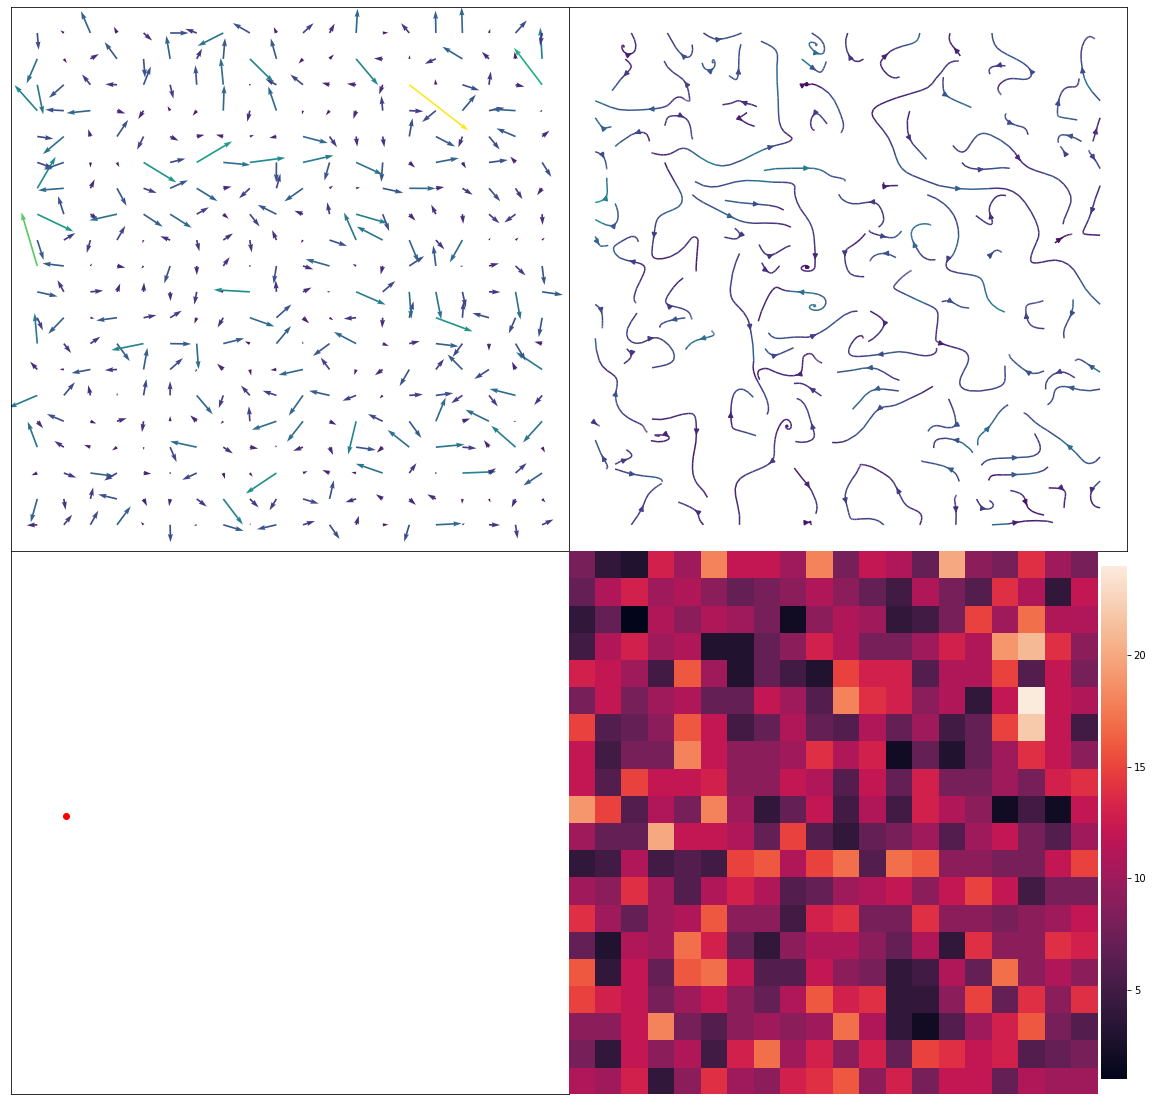

In [29]:
print('Plotting data ..')
fig = plt.figure(figsize=(20,20))
ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

timesteps = int(constants['t']) - 1


for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    #a.set_aspect('equal')
    
fig.subplots_adjust(wspace=0, hspace=0)

color = np.sqrt(U[-1]**2 + V[-1]**2)
point_size = 0.3

if with_obstacles:
    for index, o in obstacles.iterrows():
        circle1 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'orange')
        circle2 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'orange')
        #circle3 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'black')
        #circles.append(circle)
        ax[1].add_artist(circle1)
        ax[2].add_artist(circle2)
        #ax[3].add_artist(circle3)
        #ax[0].xaxis.set_ticks([])

ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[0].quiver(I, J, U[-1], V[-1], color)
ax[0].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region-1,y_max_region))

ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[1].streamplot(I, J, U[-1], V[-1], color=color, density=streamplot_density) # grid
ax[1].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region-1,y_max_region))

ax[2].xaxis.set_ticks([])
ax[2].yaxis.set_ticks([])
ax[2].plot(particles['x{}'.format(timesteps)], particles['y{}'.format(timesteps)], "o", markersize = point_size)
monomers_T = monomers_t[-1]
ax[2].plot(monomers_T['x'], monomers_T['y'], 'o', markersize = point_size * 20, color = 'red')
ax[2].set(xlim=(x_0_region,x_max_region), ylim=(y_0_region,y_max_region))

ax[3].xaxis.set_ticks([])
ax[3].yaxis.set_ticks([])
#img = ax[3].imshow(pivot, cmap='hot')
#fig.colorbar(img, ax=ax[3], fraction=0.046, pad=0.005)
sns.heatmap(pivots[-1], ax=ax[3], xticklabels = False, yticklabels = False, cbar_kws={"fraction": 0.046, "pad": 0.005})
ax[3].set(xlim=(x_0_region,x_max_region), ylim=(y_0_region,y_max_region))
#ax[3].xticks('')
#ax[3].yticks('')
ax[3].set_ylabel('')
ax[3].set_xlabel('')
#ax[1,1].imshow(pivot, cmap='hot')

plt.savefig("Assets/stationary_region.png")
#plt.close()
print('Data plotted and saved!')

In [ ]:
data_from = 'Monomers'
path = "Data/" + data_from

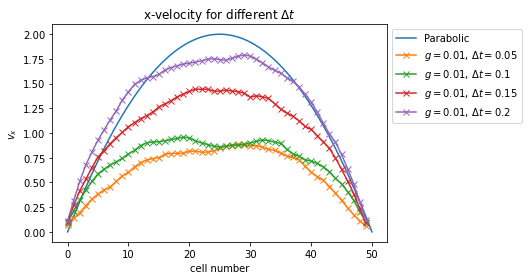

In [13]:
def viscosity(v_max, m = 1, av_N_c = 10, g = 0.01, D = 50):
    return (m * av_N_c * g * D**2) / (8 * v_max)

def parabolic_flow(y, v_max = 2, D = 50):
    return (4 * v_max * (D - y) * y)/(D**2)

def getLastCell(data_from):
    path = "Data/" + data_from
    constants = getConstants(data_from)
    last_timestep = constants['t']
    cells = pd.read_csv(path + f"cells_av{constants['avg']}_timestep{last_timestep}.csv")
    return cells

def getLastCells(data_from, num):
    path = "Data/" + data_from
    constants = getConstants(data_from)
    last_timestep = constants['t']
    start_timestep = last_timestep - num
    cells = []
    for i in range(start_timestep + 1, last_timestep + 1, 1):
        try:
            cells.append(pd.read_csv(path + f"cells_av{constants['avg']}_timestep{i}.csv"))
        except FileNotFoundError as f:
            cells.append(pd.read_csv(path + f"cells_av{constants['avg']}_timestep0{i}.csv"))
    return cells
    

y = np.linspace(0, 50, 100)
plt.plot(y, parabolic_flow(y), label = 'Parabolic')

data_dirs = ['400x50_0.01g_0.05t/', '400x50_0.01g_0.1t/', '400x50_0.01g_0.15t/', '400x50_0.01g_0.2t/']
for config in data_dirs:
    constants = getConstants(config)
    cells = getLastCells(config, 50)
    velocities_i = pd.DataFrame()
    for t, cells_t in enumerate(cells):
        cells_t.set_index(['i', 'j'], inplace = True)
        velocities_i[f'{t}'] = cells_t['meanX'].groupby('i').mean()
    plt.plot(velocities_i.mean(axis = 1), '-x', label = '$g = {}$, $\Delta t = {}$'.format(constants['g'], constants['delta_t']))
plt.legend(bbox_to_anchor=(1,1))
plt.title('x-velocity for different $\Delta t$')
plt.ylabel('$v_x$')
plt.xlabel('cell number')
#plt.savefig('Assets/poseuille.png')
plt.show()

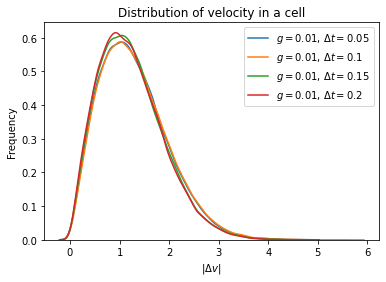

In [4]:
def getLastParticles(config):
    path = "Data/" + config
    constants = getConstants(config)
    last_timestep = constants['t']
    particles = pd.read_csv(path + f"particles_av{constants['avg']}_timestep{last_timestep}.csv")
    return particles

def theoretical_dist(Delta_v, N_c, av_N_c = 10, m = 1, k_B = 1, T = 1):
    A = (m/(2 * math.pi * k_B * T * (1 - 1/N_c)))**(3/2)
    B = np.exp(-(m/(2 * k_B * T * (1 - 1/N_c))) * Delta_v**2)
    return A * B

def poisson_avg(Delta_v, max_sum = 1000, av_N_c = 10, m = 1, k_B = 1, T = 1):
    e = math.exp(-av_N_c)
    total = 0
    for N_c in range(2, max_sum):
        P = (av_N_c**N_c)/(math.factorial(N_c))
        N = theoretical_dist(Delta_v, N_c, m, k_B, T)
        total += P * (N)
    D = 1 - (av_N_c + 1) * e
    return e * total/D

data_dirs = ['400x50_0.01g_0.05t/', '400x50_0.01g_0.1t/', '400x50_0.01g_0.15t/', '400x50_0.01g_0.2t/']
fig, ax = plt.subplots(nrows = 1, ncols = 1)
for config in data_dirs:
    constants = getConstants(config)
    particles = getLastParticles(config)
    particles["i"] = (particles["y"] / constants["a"]).apply(lambda i: floor(i))
    particles["j"] = (particles["x"] / constants["a"]).apply(lambda i: floor(i))
    cells = getLastCell(config)
    complete = pd.merge(particles, cells, how = 'inner', on = ["i", "j"])
    complete["Delta_vx"] = complete["vx"] - complete["meanX"]
    complete["Delta_vy"] = complete["vy"] - complete["meanY"]
    complete["Delta_v"] = np.sqrt(complete["Delta_vx"]**2 + complete["Delta_vy"]**2)
    mid_i = (particles["i"] >= 15) & (particles["i"] <= 35)
    subselection = complete.loc[mid_i]
    sns.kdeplot(subselection["Delta_v"]/ math.sqrt(constants["k_BT"] / constants["m"]),
                ax = ax, label = '$g = {}$, $\Delta t = {}$'.format(constants["g"], constants["delta_t"]))
    #ax.plot(subselection["Delta_v"], poisson_avg(subselection["Delta_v"]/ math.sqrt(constants["k_BT"] / constants["m"])), 'o')# ,ax = ax
ax.legend()
ax.set_title('Distribution of velocity in a cell')
ax.set_ylabel('Frequency')
ax.set_xlabel('$|\Delta v|$')
plt.savefig("Assets/Delta_v_dist.png")
plt.show()

In [5]:
def viscosity(v_max, m = 1, av_N_c = 10, g = 0.01, D = 50):
    return (m * av_N_c * g * D**2) / (8 * v_max)

def parabolic_flow(y, v_max = 1, D = 50):
    return (4 * v_max * (D - y) * y)/(D**2)

y = np.linspace(0, 50, 100)
plt.plot(y, parabolic_flow(y), label = 'Parabolic')
use = ['400x50_0.01g_0.1t/', '400x50_0.1g_0.1t/', '400x50_0.01g_0.2t/']

for config in use:
    constants = getConstants(config)
    
    cells_path = path + 'cells_av{}'.format(constants['avg'])
    columns = ['i', 'j', 'meanX', 'meanY', 'num']
    cells_timesteps = load_cells(cells_path, columns, constants['h']/constants['a'], constants['w']/constants['a'])
    I,J,U,V,pivots = prepare_cells(cells_timesteps, columns, shown_rows, shown_cols)
    
    rowsums = [row.sum()/len(row) for row in U[-1]]
    plt.plot(range(len(rowsums)), rowsums, "x-", label = f'$g = {constants['g']}, \Delta t = {constants['delta_t']}$')
    
plt.xlabel('Cell number')
plt.ylabel('x-Velocity')
plt.title('Velocity profile').format(timesteps)
plt.legend()
plt.savefig("Assets/velocity_profile.png")
#plt.close()

SyntaxError: invalid syntax (<ipython-input-5-9e10d5bb9cd9>, line 20)

In [ ]:
v_2_t = [particles[['vx{}'.format(t), 'vy{}'.format(t)]]**2 for t in range(round(len(particles.columns)/4 - 1))]
#print(v_2_t)
avg_v_2_t = [v_2_particles.sum().sum()/len(v_2_particles) for v_2_particles in v_2_t]# first col sum, then row sum (sum vxs, then sum vys)
print('Average sqared velocities after first timestep:\n{}'.format(v_2_t[0].sum()/len(v_2_t[0])))
print('Average v_x2 after last timestep:\n{}'.format(v_2_t[-1].sum()/len(v_2_t[-1])))

particle_mass = float(constants['m'])

temp_t = np.array(avg_v_2_t)
plt.plot(temp_t)
#plot = sns.lineplot(data=temp_t)
plt.xlabel('Timestep')
plt.ylabel('average of v2')
plt.title('Temperature is increasing')
plt.xlim(0,1000)
plt.savefig('Assets/temperature.png')